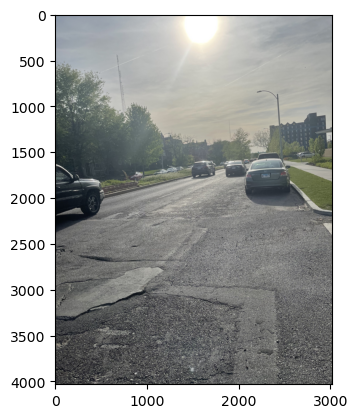

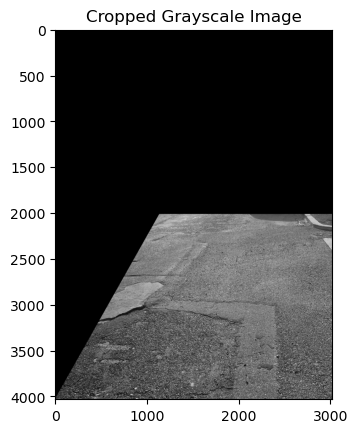

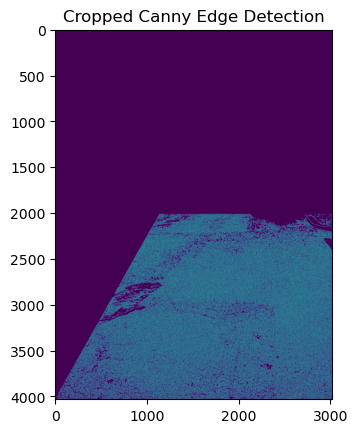

C:\Users\yjc60\AppData\Local\Temp\ipykernel_5392\1874515200.py:86: RuntimeWarning: divide by zero encountered in int_scalars
  slope = (y2 - y1) / (x2 - x1) # <-- Calculating the slope.


[[[ 467 3653 2701 2363]]

 [[  50 3981 2956 2304]]

 [[ 372 3369 3021 3369]]

 ...

 [[1200 2544 1414 2250]]

 [[1010 2762 1139 2584]]

 [[ 435 3619 1275 3619]]]


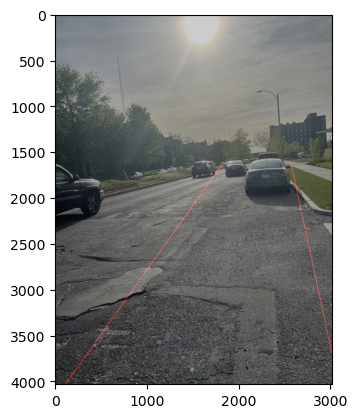

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math


image = mpimg.imread('homestreet3.jpg')
image = np.rot90(image, 3)
height=image.shape[0]
width=image.shape[1]

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = 255
    
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    if lines is None:
        return img
    img_copy = np.copy(img)
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8,
    )
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    img_copy = cv2.addWeighted(img_copy, 0.8, line_img, 1.0, 0.0)
    return img_copy



plt.figure()
plt.imshow(image)
plt.show()

gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

region_of_interest_vertices = [
    (0, height),
    (width / 2 - width / 8, height / 2),
    (width, height / 2),
    (width, height),
]

cropped_gray = region_of_interest(gray_image, np.array([region_of_interest_vertices], np.int32))
plt.figure()
plt.imshow(cropped_gray, cmap='gray')
plt.title('Cropped Grayscale Image')
plt.show()

cannyed_image = cv2.Canny(gray_image, 150, 300)
cropped_canny = region_of_interest(cannyed_image, np.array([region_of_interest_vertices], np.int32))
plt.figure()
plt.imshow(cropped_canny)
plt.title('Cropped Canny Edge Detection')
plt.show()



lines = cv2.HoughLinesP(
    cropped_canny,
    rho=4,
    theta=np.pi / 90,
    threshold=190,
    lines=np.array([]),
    minLineLength=50,
    maxLineGap=25
)

left_line_x = []
left_line_y = []
right_line_x = []
right_line_y = []
for line in lines:
    for x1, y1, x2, y2 in line:
        slope = (y2 - y1) / (x2 - x1) # <-- Calculating the slope.
        if math.fabs(slope) < 0.5: # <-- Only consider extreme slope
            continue
        if slope <= 0: # <-- If the slope is negative, left group.
            left_line_x.extend([x1, x2])
            left_line_y.extend([y1, y2])
        else: # <-- Otherwise, right group.
            right_line_x.extend([x1, x2])
            right_line_y.extend([y1, y2])
if left_line_y and right_line_y:
    poly_left = np.poly1d(np.polyfit(left_line_y, left_line_x, deg=1))
    poly_right = np.poly1d(np.polyfit(right_line_y, right_line_x, deg=1))
    min_y = int(height * (2/ 5))
    max_y = height
    left_x_start = int(poly_left(max_y))
    left_x_end = int(poly_left(min_y))
    right_x_start = int(poly_right(max_y))
    right_x_end = int(poly_right(min_y))
    line_image = draw_lines(
    image,
    [[
        [left_x_start, max_y, left_x_end, min_y],
        [right_x_start, max_y, right_x_end, min_y],
    ]],
    thickness=5,
)

print(lines)

plt.figure()
plt.imshow(line_image)
plt.show()